# Cap13 - Sistemas de Controle Digital
## PARTE 1 — Teoria, ZOH, Transformada Z, Estabilidade no Plano-z



In [1]:
!pip install control --quiet

import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

plt.rcParams['figure.figsize'] = (8,5)

print("Bibliotecas carregadas!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 7.8 MB/s eta 0:00:00
Bibliotecas carregadas!


## 1. Definindo a planta contínua usada como exemplo

Vamos trabalhar com o sistema contínuo:

\[
G(s) = \frac{1}{s(s+2)}
\]

É uma planta típica usada para discretização.


In [2]:
Gs = ctrl.tf([1], [1, 2, 0])
Gs


TransferFunction(
array([1]),
array([1, 2, 0]),
outputs=1, inputs=1)

## 2. Escolhendo o período de amostragem

O período de amostragem T influencia:
- estabilidade no plano-z  
- resolução temporal  
- precisão da implementação digital  

Vamos usar T = 0.1 s como exemplo inicial.


In [3]:
T = 0.1
T


0.1

## 3. Discretização da Planta (ZOH)

Aqui convertemos G(s) para G(z) usando retentor de ordem zero.

O ZOH é o método mais usado em CLPs e controladores industriais.


In [4]:
Gz = ctrl.sample_system(Gs, T, method='zoh')
Gz


TransferFunction(
array([0.00468269, 0.00438077]),
array([ 1.        , -1.81873075,  0.81873075]),
dt=0.1,
name='sys[0]$sampled', outputs=1, inputs=1)

## 4. Comparação da resposta ao degrau (Contínuo × Discreto)

Comparamos:
- resposta contínua  
- resposta discreta  
- efeito da amostragem  

Isso mostra o impacto de T no comportamento.


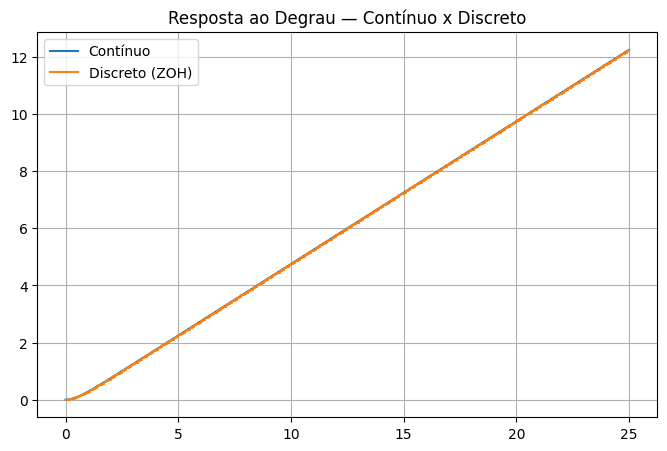

In [5]:
# Resposta contínua
t_cont, y_cont = ctrl.step_response(Gs)

# Resposta discreta
t_disc, y_disc = ctrl.step_response(Gz)

plt.plot(t_cont, y_cont, label="Contínuo")
plt.step(t_disc, y_disc, label="Discreto (ZOH)", where="post")
plt.title("Resposta ao Degrau — Contínuo x Discreto")
plt.grid()
plt.legend()
plt.show()


## 5. Estabilidade no Plano-z

Um sistema discreto é estável se **todos os polos estiverem dentro do círculo unitário**.

Vamos visualizar os polos de G(z).


In [7]:
from control.matlab import pole


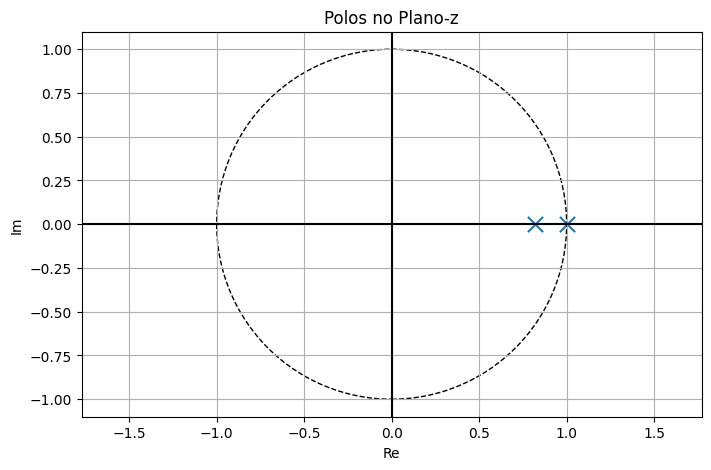

array([1.        +0.j, 0.81873075+0.j])

In [9]:
from control.matlab import pole

poles = pole(Gz)

plt.scatter(np.real(poles), np.imag(poles), marker='x', s=120)
circle = plt.Circle((0,0), 1, fill=False, linestyle='--')

plt.gca().add_patch(circle)

plt.axhline(0,color="black")
plt.axvline(0,color="black")
plt.title("Polos no Plano-z")
plt.xlabel("Re")
plt.ylabel("Im")
plt.grid()
plt.axis("equal")
plt.show()

poles


## 6. Relação entre polos contínuos e discretos

A relação fundamental é:

\[
z = e^{sT}
\]

Vamos ilustrar essa transformação graficamente para diferentes valores de T.


In [14]:
s_poles = ctrl.poles(Gs)

poles_z = [np.exp(p * T) for p in s_poles]

print("Polos contínuos:", s_poles)
print("Polos discretos:", poles_z)


Polos contínuos: [-2.+0.j  0.+0.j]
Polos discretos: [np.complex128(0.8187307530779818+0j), np.complex128(1+0j)]


## 7. Variação do período de amostragem

Vejamos o efeito de reduzir ou aumentar T na aproximação discreta.

Quanto menor T:
- mais fiel ao sistema contínuo  
- polos mais próximos do eixo real  


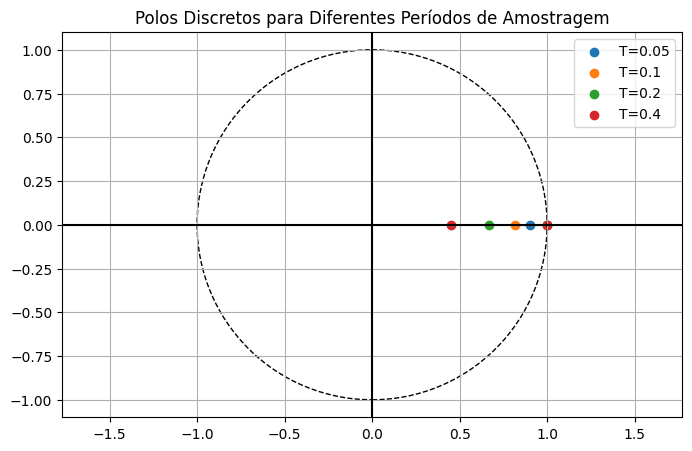

In [16]:
Ts = [0.05, 0.1, 0.2, 0.4]

plt.figure()

for T in Ts:
    Gz_temp = ctrl.sample_system(Gs, T)
    p = ctrl.poles(Gz_temp)   # ← CORREÇÃO AQUI
    plt.scatter(np.real(p), np.imag(p), label=f"T={T}")

circle = plt.Circle((0,0), 1, fill=False, linestyle='--')
plt.gca().add_patch(circle)

plt.axhline(0,color="black")
plt.axvline(0,color="black")
plt.title("Polos Discretos para Diferentes Períodos de Amostragem")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()


## 8. Função de Resposta ao Impulso

Visualizamos o comportamento discreto puro sem ZOH, analisando:

\[
h[k] = Z^{-1}\{H(z)\}
\]


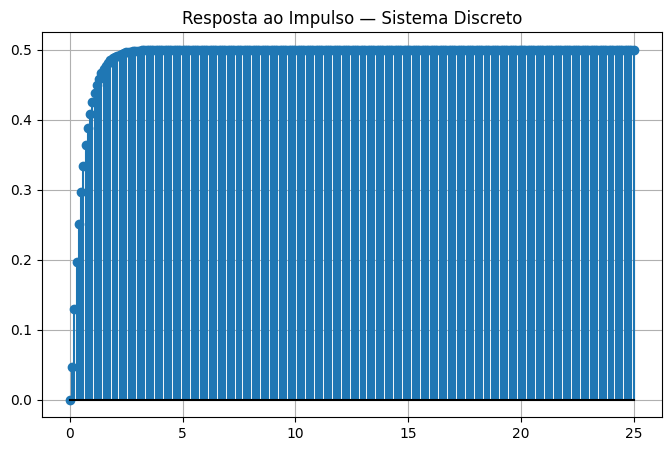

In [17]:
t_imp, y_imp = ctrl.impulse_response(Gz)

plt.stem(t_imp, y_imp, basefmt="k")
plt.title("Resposta ao Impulso — Sistema Discreto")
plt.grid()
plt.show()


## 9. Comparação entre diferentes métodos de discretização

Métodos:
- ZOH  
- Tustin  
- Forward Euler  
- Backward Euler



/usr/local/lib/python3.12/dist-packages/scipy/signal/_lti_conversion.py:74: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  num, den = normalize(num, den)   # Strips zeros, checks arrays


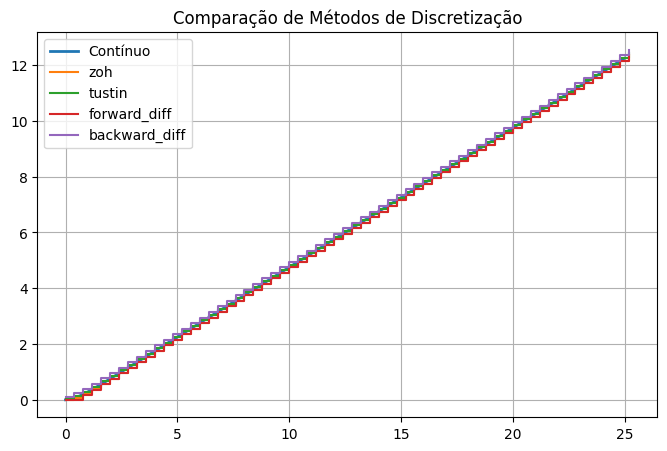

In [18]:
methods = ["zoh", "tustin", "forward_diff", "backward_diff"]

plt.figure()
t_cont, y_cont = ctrl.step_response(Gs)
plt.plot(t_cont, y_cont, label="Contínuo", linewidth=2)

for m in methods:
    G_temp = ctrl.sample_system(Gs, T, method=m)
    t,y = ctrl.step_response(G_temp)
    plt.step(t,y, where="post", label=m)

plt.title("Comparação de Métodos de Discretização")
plt.legend()
plt.grid()
plt.show()
